# 2000년대 유행어

In [2]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

C:\Users\cutad\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df = pd.read_csv('../data_inword/2000년대 유행어.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20230310,안녕하세요 디벨롭스토리즈입니다! '시대의 변화에 따라 새로운 것들을 표현하기 위해 ...,신조어들 2000년대에도 신조어가 존재했다는데요 Y2K 시리즈! 그 시절 유행어에 ...,2000년대에도 신조어가 있었다?! Y2K 유행 파헤쳐 보기! 그 시절 옛날 유행어...
1,20190607,스마트 친구들 안녕 곧 주말이라 신나는 이 시간!! 지난 5월 27일부터 6월 2일...,지난 5월 27일부터 6월 2일 까지 진행한 <b>2000년대 유행어<\/b> 맞주...,[당첨자 발표] 2000년대 유행어 맞추기 이벤트
2,20231222,"여러분 안녕하세요. 그린랜드입니다 ^^ 오늘은 2023년을 마무리하며, 올한해 일본...","그린랜드입니다 ^^ 오늘은 2023년을 마무리하며, 올한해 일본의 신조어・<b>유행...",2023년 일본 신조어/유행어 TOP 10 (+후보 리스트)
3,20220502,안녕하세요. 시사중국어사 24기 기자단 신혜빈입니다. 여러분은 평소에 줄임말 자주 ...,오늘은 중국의 MZ세대가 쓰는 중국어 <b>유행어<\/b>에는 어떤 것이 있는지 또...,이것만 알면 나도 핵인싸? 중국의 MZ세대 줄임말과 유행어
4,20200316,본문을 찾을 수 없습니다,https:\/\/kr.theepochtimes.com\/%eb%90%9c%ec%9...,제목을 찾을 수 없습니다


## 1. 전처리

In [4]:
## 사용자 정의 단어 추가 
kiwi = Kiwi()

new = ['KIN', 'Kin', 'kin', '즐', '엽기', '지대', '방가', '하이', '헐', '대박', 
       '당근이지', '당빠지', '우왕', 'ㅋ', '굳', '킹왕짱', '킹왕짱이다', '소고기', 
       '500원', '궁금하면', '궁금', '지못미', '대략난감', '귀여니', '쉽살재빙', '거북이', '빙고', 
       '대박', '간지', '오나전', '초딩', '뷁', '얼짱', '오타쿠', '빠순이', 'OTL', '안습', '고고씽', 
       '쩔어', '훈남', '완소', '님', '짱', '여신', '엄친아', '듣보잡', '뭥미', '품절남', '빵꾸똥꾸']

for i in new:
    kiwi.add_user_word(i,'NNP')

In [5]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [24]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = ['사람', '대하', '시작', '일본', '사용', '한국', '사랑', '때문', '중국', '사진', 
                        '미국', '사회', '영상', '단어', '표현', '정도', '인기', '배우', '모습', '이야기', 
                        '활동', '세대', '출처', '세계', '마음', '친구', '가지', '유행', '작품', '출연', 
                        '이후', '상황', '다양', '관련', '최고', '가능', '게임', '대상', '처음', '일상', 
                        '요즘', '보이', '진행', '프로그램', '시대', '앨범', '소개', '성공', '느낌', '정보', 
                        '콘텐츠', '오늘', '생활', '내용', '기업', '투자', '음악', '경제', '대표', '캐릭터', 
                        '시장', '광고', '트렌드', '이름', '부분', '필요', '가족', '기억', '이유', '인터넷', 
                        '경우', '성장', '세상', '관심', '당시', '온라인', '마지막', '등장', '기록', '사이', 
                        '인하', '영어', '데뷔', '발표', '공개', '개인', '나라', '중요', '자리', '회사', 
                        '여자', '서울', '기준', '채널', '대한민국', '변화', '소비', '제품', '경험', '감독', 
                        '추천', '기술', '국내', '학교', '여성', '스타', '나이', '유명', '이미지', '방법', 
                        '연기', '활용', '지금', '남자', '인생', '서비스', '제작', '정부', '시절', '개그맨', 
                        '가수', '브랜드', '이해', '최근', '결과', '미래', '이용', '코미디', '현실', '평가', 
                        '과거', '사건', '설명', '지역', '참여', '과정', '공간', '예능', '시청', '개봉', 
                        '사실', '의미', '대학', '환경', '자체', '방식', '해당', '장면', '산업', '본인', 
                        '주인공', '결혼', '국가', '주목', '존재', '대중', '디지털', '년대', '관계', '용어', 
                        '작가', '가치', '분위기', '언어', '역사', '현상', '중심', '역할', '시기', '생산', 
                        '분석', '시리즈', '선수', '스타일', '특징','공유', '정치', '본문', '상대', '경기', 
                        '패션', '생각', '유행어', '신조어', '초반', '조직', '스톤', '콜드', '반도체', '중반', 
                        '남성', '최초', '연구', '언급', '출생', '제공', '개발', '노력', '일부', '마케팅', 
                        '운동', '전체', '교육', '인물', '이전', '출시', '조미', '인간', '기존', '소통', 
                        '현대', '올해', '반응', '줄임', '영향', '배경', '가격', '코로나', '사업', '장르', 
                        '전쟁', '국민', '유지', '탄생', '선택', '공감', '구성', '라면', '도시', '효과', 
                        '테스트', '동시', '차이', '능력', '거리', '경쟁', '대사', '증가', '자연', '얼굴', 
                        '감정', '모델', '상품', '후반', '매력', '전략', '그룹', '주연', '커피', '방영', 
                        '수준', '관객', '운영', '상태', '연애', '거래', '일반', '플랫폼', '기반', '화제', 
                        '소비자', '제목', '발전', '출신', '목소리', '무대']

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = '../stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [25]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [26]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    # wordclass_column = 'wordclass_' + column 
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 1min 31s
Wall time: 4min 58s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20230310,안녕하세요 디벨롭스토리즈입니다 시대의 변화에 따라 새로운 것들을 표현하기 위해 새롭...,신조어들 2000년대에도 신조어가 존재했다는데요 Y2K 시리즈 그 시절 유행어에 대...,2000년대에도 신조어가 있었다 Y2K 유행 파헤쳐 보기 그 시절 옛날 유행어 지대...,안녕하세요 디벨 롭 스토리 기 사전 정의 데 생성 말 중 엽기 지대 은 위 뜻 지 ...,중 엽기 지대 은 위,도 보기 옛날 지대 엽기 즐 뜻
1,20190607,스마트 친구들 안녕 곧 주말이라 신나는 이 시간 지난 5월 27일부터 6월 2일 까...,지난 5월 27일부터 6월 2일 까지 진행한 b2000년대 유행어b 맞주기 이벤트 ...,당첨자 발표 2000년대 유행어 맞추기 이벤트,스마트 주말 라 지나 맞주기 이벤트 당첨자 퀴즈 이벤트 주 답 좌절 습기 고고씽 제...,지나 맞주기 이벤트 당첨자 퀴즈 이벤트 주,당첨자 이벤트
2,20231222,여러분 안녕하세요 그린랜드입니다 오늘은 2023년을 마무리하며 올한해 일본의 신조어...,그린랜드입니다 오늘은 2023년을 마무리하며 올한해 일본의 신조어b유행어b를 Y2K...,2023년 일본 신조어유행어 TOP 10 후보 리스트,그린랜드 은 마무리 해 도 수 알 아레 아레 일본어 거 뜻 요 야구 구단 한신 타이...,그린랜드 은 마무리 해 복장,후보 리스트
3,20220502,안녕하세요 시사중국어사 24기 기자단 신혜빈입니다 여러분은 평소에 줄임말 자주 쓰시...,오늘은 중국의 MZ세대가 쓰는 중국어 b유행어b에는 어떤 것이 있는지 또 어떤 줄임...,이것만 알면 나도 핵인싸 중국의 MZ세대 줄임말과 유행어,안녕하세요 시사 중 국어사 기 기자단 신혜 빈 은 평소 줄 말 유학 더치페이 말 계...,은 중국어 밀레 얼 제트 초 초,만 핵 인 말
4,20200316,본문을 찾을 수 없습니다,httpskrtheepochtimescomeb909cec9ea5eb8580c2b7e...,제목을 찾을 수 없습니다,수,,수


In [45]:
# 전처리한 결과 csv로 저장 
df.to_csv('2000유행어_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [27]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts


### [preprocessed_body]

In [28]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [32]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
16322,영화,1431
5652,드라마,1286
8104,문화,870
3998,노래,615
8077,문제,581
9099,방송,556
17938,유튜브,363
17587,웹툰,273
13338,스톤,255
23818,콜드,253


In [33]:
l = []
for i in top_30_words['word']:
    l.append(i)
l

['영화',
 '드라마',
 '문화',
 '노래',
 '문제',
 '방송',
 '유튜브',
 '웹툰',
 '스톤',
 '콜드',
 '힙합',
 '커뮤니티',
 '개그',
 '심현섭',
 '추억',
 '미디어',
 '재미',
 '애니메이션',
 '행복',
 '인정',
 '오스틴',
 '공부',
 '행동',
 '요소',
 '김영철',
 '업체',
 '기사',
 '예술',
 '연출',
 '준비']

In [34]:
## 한 번 해본 것

for i in all_words_body['word']:
    if i in new:
        count = all_words_body.loc[all_words_body['word'] == i, 'count'].values[0]
        print(f"The count for '{i}' is: {count}")

The count for '오타쿠' is: 96
The count for '궁금' is: 52
The count for '엽기' is: 44
The count for '지대' is: 41
The count for '하이' is: 33
The count for '초딩' is: 21
The count for '얼짱' is: 19
The count for '빙고' is: 14
The count for '소고기' is: 11
The count for '거북이' is: 9
The count for '대박' is: 8
The count for '킹왕짱' is: 8
The count for '쉽살재빙' is: 7
The count for '지못미' is: 7
The count for '귀여니' is: 6
The count for '간지' is: 6
The count for '뭥미' is: 5
The count for '고고씽' is: 5
The count for '완소' is: 4
The count for '빵꾸똥꾸' is: 4
The count for '우왕' is: 4
The count for '여신' is: 4
The count for '듣보잡' is: 3
The count for '방가' is: 2
The count for '쩔어' is: 1
The count for '당빠지' is: 1
The count for '엄친아' is: 1


### [preprocessed_description]

In [35]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_word_counts = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_word_counts = all_word_counts[all_word_counts['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_word_counts.head(30)
top_30_words

,word,count
391,드라마,34
1105,영화,21
1517,추억,18
1701,프로필,14
964,심현섭,13
1813,후기,13
1201,유래,12
271,노래,11
532,모음,11
557,문화,11


### [preprocessed_title]

In [36]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_word_counts = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_word_counts = all_word_counts[all_word_counts['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_word_counts.head(30)
top_30_words

,word,count
824,드라마,96
2308,영화,88
1205,밀레,49
1156,문화,47
75,개그,39
573,노래,36
3258,추억,32
3378,코너,27
2002,심현섭,22
1290,방송,21


# 3. TF-IDF

In [11]:
# ## 참고 사이트
# ## -> https://foreverhappiness.tistory.com/30
# ## -> https://foreverhappiness.tistory.com/35
# ## -> https://foreverhappiness.tistory.com/37
# ## 너무 오래 걸려서 안 돌림


# import pandas as pd
# from tqdm import tqdm
# from konlpy.tag import Okt
# from sklearn.feature_extraction.text import CountVectorizer

# # DTM (Document-Term Matrix) creation using Scikit-Learn's CountVectorizer
# # DTM(Document-Term Matrix) 생성 함수
# def NLP_DTM(df):
#     # 타이틀 리스트를 데이터프레임의 'preprocessed_title' 열에서 가져옴
#     title_lst = df['preprocessed_title']
    
#     # 불용어 리스트를 정의
#     stop_words_list = ['사람', '대하']
    
#     # Okt 형태소 분석기를 초기화
#     tagger = Okt()

#     # 결과를 저장할 DataFrame 초기화
#     result_df = pd.DataFrame()

#     # 타이틀 리스트를 순회하며 진행도를 표시
#     for title in tqdm(title_lst, desc='타이틀 리스트 진행도'):
#         # CountVectorizer 객체를 초기화
#         cv = CountVectorizer()

#         # 각 문서의 말뭉치를 저장할 리스트를 초기화
#         corpus = []

#         # 문서 진행도를 표시하며 타이틀 리스트의 각 요소에 대해 반복
#         for i in tqdm(range(len(df['preprocessed_body'])), desc='문서 진행도'):
#             # 각 타이틀에 대해 명사 리스트를 생성합니다.
#             n_lst = tagger.nouns(df['preprocessed_body'].iloc[i])
#             corpus.append(' '.join(n_lst))

#         # 말뭉치 데이터를 사용해 DTM(Document-Term Matrix)을 생성
#         DTM_array = cv.fit_transform(corpus).toarray()
        
#         # DTM의 각 열이 어떤 단어에 해당하는지 feature_names에 저장
#         feature_names = cv.get_feature_names_out()

#         # DTM 배열을 DataFrame 형식으로 변환
#         DTM_df = pd.DataFrame(DTM_array, columns=feature_names)
        
#         # 불용어 리스트에 있는 단어들을 DTM DataFrame에서 제거
#         DTM_df.drop(columns=stop_words_list, inplace=True, errors='ignore')
        
#         # 결과 DataFrame에 현재 DTM DataFrame을 추가
#         result_df = pd.concat([result_df, DTM_df], axis=0)

#     return result_df


# # %%time
# dtm_df = NLP_DTM(df)
# dtm_df

## 교수님 코드

In [37]:
## DTM (Document Term Matrix)
## 이거 안 하고 바로 TF-IDF로 가도 됨

import pandas as pd
from tqdm import tqdm
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer


documents = df['preprocessed_body']
word_dict = all_word_counts['word']
vector = CountVectorizer(vocabulary=word_dict)
results = vector.fit_transform(documents).toarray()

results

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
## TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

documents = df['preprocessed_body']
word_dict = all_word_counts['word']
vector = CountVectorizer(vocabulary=word_dict)
dtm = vector.fit_transform(documents).toarray()


vector = TfidfVectorizer(vocabulary=word_dict)
tfidf = vector.fit_transform(documents).toarray()

tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04337172, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.01918424, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.08980929, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [39]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 가정: df는 미리 전처리된 텍스트 데이터 프레임
documents = df['preprocessed_body']
word_dict = all_word_counts['word'].tolist()

# TF-IDF 계산
vectorizer = TfidfVectorizer(vocabulary=word_dict)
tfidf_matrix = vectorizer.fit_transform(documents).toarray()

# 각 단어의 TF-IDF 값을 집계
tfidf_scores = tfidf_matrix.sum(axis=0)
words = vectorizer.get_feature_names_out()

# 데이터 프레임 생성
tfidf_df = pd.DataFrame({'words': words, 'counts': tfidf_scores})

# TF-IDF 값이 큰 순서로 정렬
tfidf_df = tfidf_df.sort_values(by='counts', ascending=False).reset_index(drop=True)


tfidf_df

,words,counts
0,영화,26.699644
1,드라마,25.479827
2,문화,18.282718
3,노래,15.758955
4,방송,13.123314
...,...,...
3613,빠링허우,0.000000
3614,아우러서,0.000000
3615,아스널,0.000000
3616,대신증권,0.000000


In [40]:
## 한 번 해본 것

for i in tfidf_df['words']:
    if i in new:
        count = tfidf_df.loc[tfidf_df['words'] == i, 'counts'].values[0]
        print(f"The count for '{i}' is: {count}")

The count for '엽기' is: 2.7716970448935614
The count for '오타쿠' is: 2.6583593345265912
The count for '지대' is: 2.6322634287511812
The count for '궁금' is: 2.547052792204065
The count for '초딩' is: 2.2992027874917778
The count for '얼짱' is: 1.6658776548602061
The count for '하이' is: 1.195551493607929
The count for '뭥미' is: 1.0123556505661857
The count for '지못미' is: 0.9453168523778914
The count for '고고씽' is: 0.8371414171333253
The count for '대박' is: 0.7962789091908756
The count for '킹왕짱' is: 0.754188759319433
The count for '간지' is: 0.5041164111108318
The count for '완소' is: 0.4069999593087401
The count for '우왕' is: 0.4018374806237541
The count for '여신' is: 0.23673175563540644
The count for '엄친아' is: 0.162843952891038
The count for '쩔어' is: 0.162843952891038


# 4. 워드 클라우드

## 필요한 모듈 임포트

In [41]:
from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline

import konlpy

## WordCloud 클래스의 객체 생성

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [42]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [43]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'영화': 1431,
 '드라마': 1286,
 '문화': 870,
 '노래': 615,
 '문제': 581,
 '방송': 556,
 '유튜브': 363,
 '웹툰': 273,
 '스톤': 255,
 '콜드': 253,
 '힙합': 242,
 '커뮤니티': 236,
 '개그': 219,
 '심현섭': 217,
 '추억': 201,
 '미디어': 200,
 '재미': 188,
 '애니메이션': 187,
 '행복': 173,
 '인정': 172,
 '오스틴': 172,
 '공부': 170,
 '행동': 169,
 '요소': 168,
 '김영철': 167,
 '업체': 167,
 '기사': 166,
 '예술': 166,
 '연출': 166,
 '준비': 165,
 '가사': 165,
 '감성': 163,
 '시즌': 163,
 '확인': 163,
 '프로': 162,
 '장기': 162,
 '멤버': 162,
 '포함': 162,
 '편집': 161,
 '촬영': 161,
 '주제': 161,
 '네이버': 160,
 '구조': 160,
 '해외': 159,
 '아버지': 159,
 '판매': 159,
 '현재': 159,
 '그림': 158,
 '졸업': 157,
 '하루': 157,
 '스토리': 156,
 '수상': 156,
 '이선균': 155,
 '인식': 155,
 '교수': 155,
 '부동산': 155,
 '인상': 154,
 '주장': 154,
 '형성': 153,
 '위기': 153,
 '흥행': 152,
 '고민': 152,
 '기간': 151,
 '노동자': 151,
 '비하': 150,
 '추구': 150,
 '정책': 150,
 '코너': 148,
 '순간': 148,
 '진출': 148,
 '루피': 147,
 '대신': 147,
 '지속': 147,
 '예전': 147,
 '극장': 146,
 '성격': 146,
 '대화': 146,
 '어머니': 146,
 '관리': 145,
 '적극': 145,
 '소설': 145,
 '주요': 1

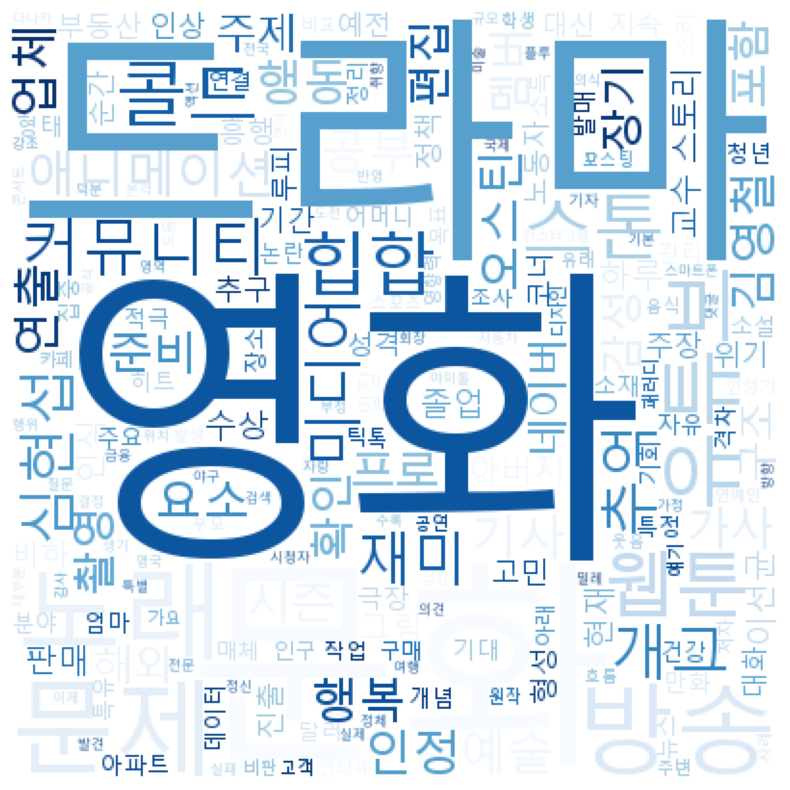

In [44]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Purples')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기